# Sandbox for testing FastSurfer model
- https://github.com/nikhil153/FastSurfer

In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dask import compute, delayed
import dask.multiprocessing


### Paths

In [13]:
project_dir = '../'
exp_dir = '{}/FastSurfer_experiments/'.format(project_dir)
results_dir = '{}results/prunning/ukb/'.format(exp_dir)

In [14]:
def convert_mgz_to_nifti(mgz_file):
    nii_file = mgz_file.rsplit('.',1)[0] + '.nii.gz'
    mgh = nib.load(mgz_file)
    nib.save(mgh, nii_file)

def dice_coef(y_true, y_pred, smooth=1):
    y_true = y_true.ravel()
    y_pred = y_pred.ravel()
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    dice = np.mean((2. * intersection + smooth)/(union + smooth))
    return dice

def get_multi_label_dice(label_list, y_true, y_pred):
    ''' Calculates label-wise dice score for a 3D segmentation volume
    '''
    # # Dask based parallel compute
    values = [delayed(dice_coef)(y_true == label, y_pred == label) 
              for label in label_list]

    dice_list = compute(*values, scheduler='threads',num_workers=6) 
    dice_dict = dict(zip(label_list,dice_list)) 

    return pd.DataFrame(list(dice_dict.items()),columns=['label','dice'])

### Rough work (sample file converstion)

In [8]:
# mgz_file = "/home/nikhil/Downloads/TaskRawWorkdir-FreeSurferReconAll-1807617-1/sub-2017717/mri/aparc.DKTatlas+aseg.mgz" #"/home/nikhil/Downloads/orig.mgz"   #aparc.DKTatlas+aseg.deep.mgz"
# mgz_file = "/home/nikhil/Desktop/orig.mgz" 
# convert_mgz_to_nifti(mgz_file)

## Sample case

In [4]:
FreeSurfer_label = "/home/nikhil/Downloads/TaskRawWorkdir-FreeSurferReconAll-1807617-1/sub-2017717/mri/aparc.DKTatlas+aseg.mgz"
FastSurfer_label = "/home/nikhil/Downloads/aparc.DKTatlas+aseg.deep.mgz"

fs_seg = nib.load(FreeSurfer_label).get_fdata()
deep_seg = nib.load(FastSurfer_label).get_fdata()
unique_labels = set(fs_seg.ravel())
print('{} unique labels found'.format(len(unique_labels)))
dice_df = get_multi_label_dice(unique_labels, fs_seg, deep_seg)

dice_df['prunning'] = 'orig'

104 unique labels found


In [17]:
FastSurfer_label = "/home/nikhil/Downloads/aparc.DKTatlas+aseg.deep_prune_50.mgz"
deep_seg = nib.load(FastSurfer_label).get_fdata()
print('{} unique labels found'.format(len(unique_labels)))
dice_df_prune_50 = get_multi_label_dice(unique_labels, fs_seg, deep_seg)

dice_df_prune_50['prunning'] = '50%'

104 unique labels found


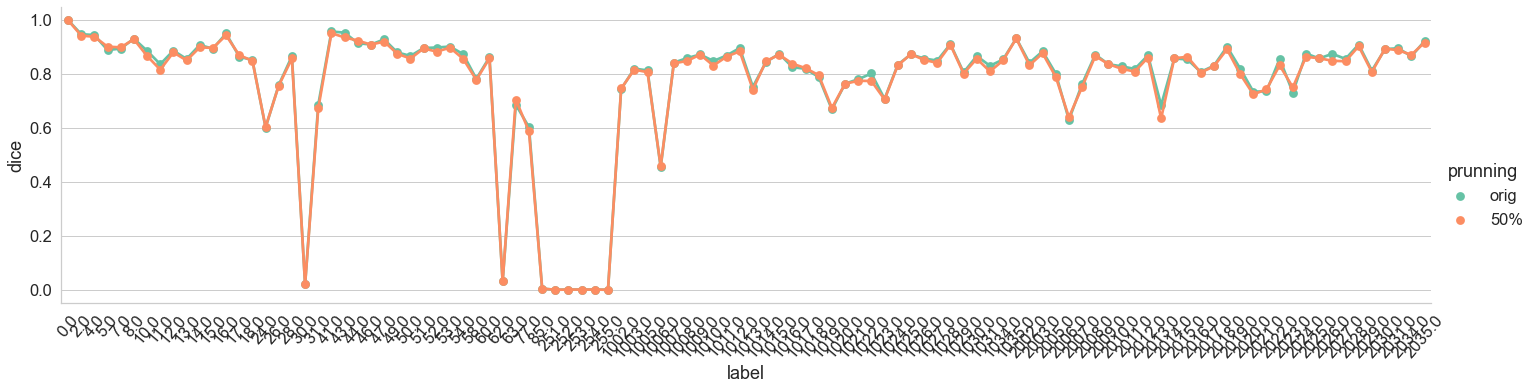

In [19]:
plot_df = dice_df.append(dice_df_prune_50)
plot_df = plot_df.sort_values(['label'])
plot_df['label'] = plot_df['label'].astype(str)
sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='label',y='dice', hue='prunning', kind='point', data=plot_df, palette='Set2',height=5, aspect=4, sharex=True, sharey=True)
    g.set_xticklabels(rotation=50)

## Cohort performances

In [15]:
# mni dataset
# FreeSurfer_label_dir = '/home/nikhil/projects/Parkinsons/data/fs60/segmentations/'
# FastSurfer_label_dir = '/home/nikhil/projects/green_comp_neuro/FastSurfer/data/'

# ukb dataset
FreeSurfer_label_dir = '/home/nikhil/projects/green_comp_neuro/output/fs6.0/'
FastSurfer_label_dir = '/home/nikhil/projects/green_comp_neuro/FastSurfer/output/'

ignore_subjects = {'sub-1009760'}

In [16]:
cohort = 'ukb'
prunnings = ['prune_0'] #['prune_10','prune_25','prune_50','prune_75','prune_90']
save_perf = True

for prunning in prunnings:
    FreeSurfer_subjects = os.listdir('{}{}'.format(FreeSurfer_label_dir,cohort))
    FastSurfer_subjects = os.listdir('{}{}/{}'.format(FastSurfer_label_dir,cohort, prunning))
    common_subject = list(set(FastSurfer_subjects) & set(FreeSurfer_subjects) - ignore_subjects)

    print('n subjects, FreeSurfer:{}, FastSurfer:{}, common:{}'.format(len(FreeSurfer_subjects), len(FastSurfer_subjects), len(common_subject)))

    dice_df_concat = pd.DataFrame()
    for s, sub in enumerate(common_subject):
        print('Subject id: {},{}'.format(s,sub))
        FreeSurfer_label = FreeSurfer_label_dir + '{}/{}/aparc.DKTatlas+aseg.mgz'.format(cohort,sub)
        FastSurfer_label = FastSurfer_label_dir + '{}/{}/{}/aparc.DKTatlas+aseg.deep.mgz'.format(cohort,prunning,sub)

        fs_seg = nib.load(FreeSurfer_label).get_fdata()
        deep_seg = nib.load(FastSurfer_label).get_fdata()

        if s == 0:
            unique_labels = set(fs_seg.ravel())
            print('{} unique labels found'.format(len(unique_labels)))

        dice_df = get_multi_label_dice(unique_labels, fs_seg, deep_seg)
        dice_df['prunning'] = prunning
        dice_df['cohort'] = cohort
        dice_df['subject_id'] = sub
        dice_df_concat = dice_df_concat.append(dice_df)

    if save_perf:
        dice_csv = results_dir + '{}/dice_perf.csv'.format(prunning)
        dice_df_concat.to_csv(dice_csv)




n subjects, FreeSurfer:73, FastSurfer:73, common:72
Subject id: 0,sub-1000011
107 unique labels found
Subject id: 1,sub-1518902
Subject id: 2,sub-1232770
Subject id: 3,sub-1061245
Subject id: 4,sub-1127906
Subject id: 5,sub-1005221
Subject id: 6,sub-1035366
Subject id: 7,sub-2316147
Subject id: 8,sub-1081696
Subject id: 9,sub-4245899
Subject id: 10,sub-3875050
Subject id: 11,sub-3614538
Subject id: 12,sub-2810142
Subject id: 13,sub-1000394
Subject id: 14,sub-1044475
Subject id: 15,sub-1599957
Subject id: 16,sub-1450654
Subject id: 17,sub-1033401
Subject id: 18,sub-1050772
Subject id: 19,sub-1473014
Subject id: 20,sub-1110743
Subject id: 21,sub-2014383
Subject id: 22,sub-1762288
Subject id: 23,sub-1530211
Subject id: 24,sub-1000083
Subject id: 25,sub-1021576
Subject id: 26,sub-1474044
Subject id: 27,sub-1006569
Subject id: 28,sub-1112423
Subject id: 29,sub-1005469
Subject id: 30,sub-1088341
Subject id: 31,sub-1013261
Subject id: 32,sub-5142605
Subject id: 33,sub-4246203
Subject id: 34,s

FileNotFoundError: [Errno 2] No such file or directory: '..//FastSurfer_experiments/results/prunning/ukb/prune_0/ukb/dice_perf.csv'

In [19]:
dice_df_concat

,label,dice,prunning,cohort,subject_id
0,0.0,0.998714,prune_0,ukb,sub-1000011
1,1025.0,0.905070,prune_0,ukb,sub-1000011
2,1026.0,0.883758,prune_0,ukb,sub-1000011
3,2.0,0.969205,prune_0,ukb,sub-1000011
4,1028.0,0.927627,prune_0,ukb,sub-1000011
...,...,...,...,...,...
102,1019.0,0.811981,prune_0,ukb,sub-1838053
103,1020.0,0.783576,prune_0,ukb,sub-1838053
104,1021.0,0.791441,prune_0,ukb,sub-1838053
105,1022.0,0.860791,prune_0,ukb,sub-1838053


## Load previously saved perf

In [30]:
dice_df_concat = pd.DataFrame()
cohorts = ['ukb'] #['NC,'ET','PD']
prunnings = ['prune_0'] #
for prunning in prunnings:
    for cohort in cohorts:
        dice_csv = results_dir + '{}/dice_perf.csv'.format(prunning)
        dice_df = pd.read_csv(dice_csv)
        dice_df['prunning'] = prunning
        dice_df_concat = dice_df_concat.append(dice_df)

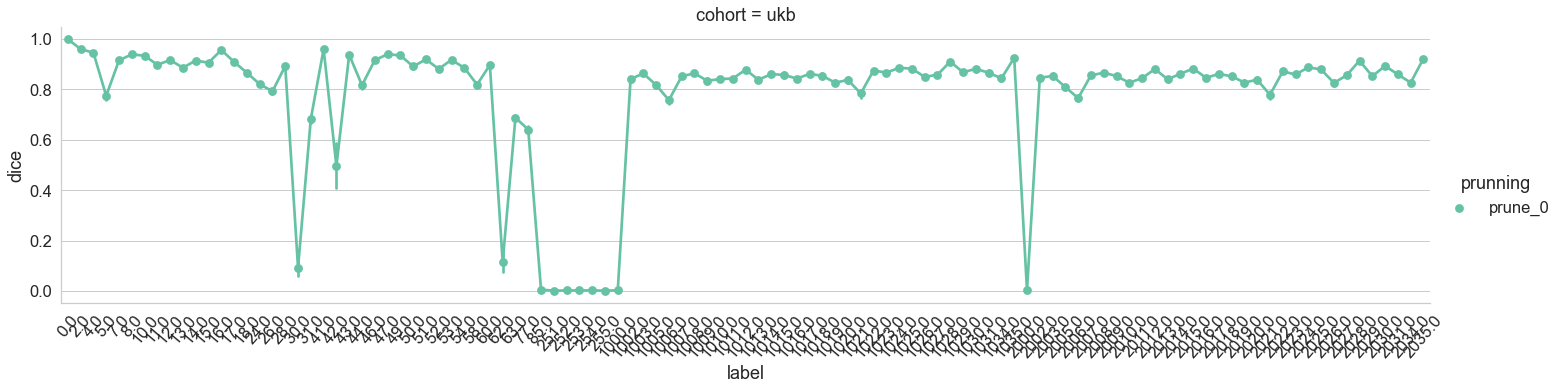

In [31]:
plot_df = dice_df_concat.copy()
plot_df = plot_df.sort_values(['label'])
plot_df['label'] = plot_df['label'].astype(str)
hue_order = prunnings
sns.set(font_scale = 1.5)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='label',y='dice', hue='prunning', col='cohort', col_wrap=1, kind='point', hue_order=hue_order ,data=plot_df, palette='Set2',height=5, aspect=4, sharex=True, sharey=True)
    g.set_xticklabels(rotation=50)


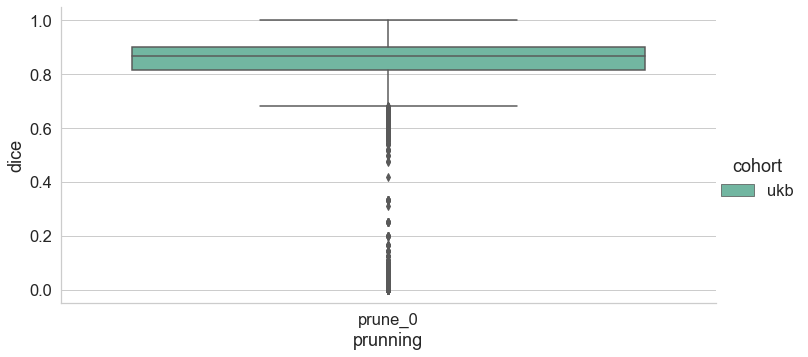

In [22]:
plot_df = dice_df_concat.copy()
plot_df = plot_df.sort_values(['label'])
plot_df['label'] = plot_df['label'].astype(str)

cohorts = ['ukb']
sns.set(font_scale = 1.5)
hue_order = cohorts
x_order = prunnings
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='prunning',y='dice', hue='cohort', kind='box', data=plot_df, palette='Set2', order=x_order, hue_order=hue_order, height=5, aspect=2, sharex=True, sharey=True)
    


## Filter performance of stable ROIs

In [27]:
dice_thresh = 0.5
label_df = dice_df_concat[dice_df_concat['prunning']=='prune_0'].groupby(['label']).median().reset_index()
stable_ROIs = label_df[label_df['dice']>dice_thesh]['label'].unique()
print('theshold: {}, number of stable ROIs: {}'.format(dice_thresh, len(stable_ROIs)))

theshold: 0.5, number of stable ROIs: 96


(81205, 6)
(65479, 6)


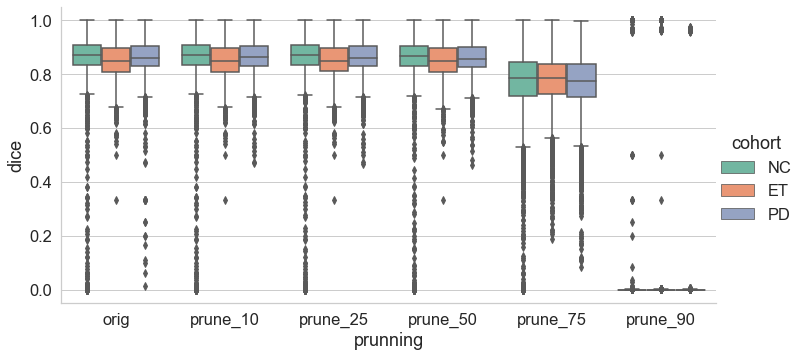

In [34]:
plot_df = dice_df_concat.copy()
print(plot_df.shape)
plot_df = plot_df[plot_df['label'].isin(stable_ROIs)]
print(plot_df.shape)
plot_df = plot_df.sort_values(['label'])
plot_df['label'] = plot_df['label'].astype(str)

sns.set(font_scale = 1.5)
hue_order = cohorts
x_order = prunnings
with sns.axes_style("whitegrid"):
    g = sns.catplot(x='prunning',y='dice', hue='cohort', kind='box', data=plot_df, palette='Set2', order=x_order, hue_order=hue_order, height=5, aspect=2, sharex=True, sharey=True)